In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split


#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import KFold
#from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

from pickle import dump

warnings.filterwarnings('ignore')


pd.options.display.float_format = "{:,.2f}".format

In [2]:
df2018 = pd.read_csv('DADOS/MICRODADOS_ENEM_2018.csv',
                     nrows = 100000, sep = ';', encoding = 'ISO-8859-1')


df2018.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180008202043,2018,5300108,Brasília,53,DF,44.00,M,1.00,1,...,A,A,A,A,A,A,A,A,B,A
1,180007197856,2018,2111102,São João dos Patos,21,MA,23.00,F,0.00,3,...,A,B,A,A,B,A,A,A,A,A
2,180008517434,2018,3530607,Mogi das Cruzes,35,SP,23.00,F,0.00,1,...,A,B,A,A,B,B,B,B,A,A
3,180007661228,2018,2916401,Itapetinga,29,BA,26.00,F,0.00,3,...,A,B,B,A,C,A,B,B,A,A
4,180008787987,2018,2918100,Jeremoabo,29,BA,20.00,M,0.00,0,...,A,B,A,A,B,A,B,B,B,A


## Data cleaning

### Removing some irrelevant columns

Some columns can be seen directly as been irrelevant for us, the first of them is
the enrollment number, since we are interested in the social information and this
is an individual number to each applicant. Another one is the NU_ANO, since it
corresponds to the year of the specific national exam. Also 'CO_MUNICIPIO_RESIDENCIA'
is equivalent to 'NO_MUNICIPIO_RESIDENCIA' and 'CO_UF_RESIDENCIA' is equivalent to 'SG_UF_RESIDENCIA'.

In [3]:
cols = ['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'CO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'TP_NACIONALIDADE', 'NO_MUNICIPIO_NASCIMENTO', 'SG_UF_NASCIMENTO']

df2018 = df2018.drop(columns = cols)

df2018.head()

,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,Brasília,DF,44.00,M,1.00,1,2,0,2,1.00,...,A,A,A,A,A,A,A,A,B,A
1,São João dos Patos,MA,23.00,F,0.00,3,1,5,1,1.00,...,A,B,A,A,B,A,A,A,A,A
2,Mogi das Cruzes,SP,23.00,F,0.00,1,1,3,1,3.00,...,A,B,A,A,B,B,B,B,A,A
3,Itapetinga,BA,26.00,F,0.00,3,1,8,1,1.00,...,A,B,B,A,C,A,B,B,A,A
4,Jeremoabo,BA,20.00,M,0.00,0,2,0,2,1.00,...,A,B,A,A,B,A,B,B,B,A


For the model prediction, we are also not interested in information regarding the answers
given by the students at the answer card. Nor the test informations, like the test number and so on

In [4]:
cols = ['CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'TX_GABARITO_CN',
        'TX_GABARITO_CH', 'TX_GABARITO_LC','TX_GABARITO_MT','TP_STATUS_REDACAO',
        'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

df2018 = df2018.drop(columns = cols)

### Analyzing absent applicants

The columns containing "PRESENCA" in the name, tells us when the applicants were present 
or not in the test. Let's analyze this and also remove those applicants which were absent

In [5]:
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 0]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 1]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 2]))

## Removing those which didn't show up for the test

df2018 = df2018[(df2018.TP_PRESENCA_CN == 1) & (df2018.TP_PRESENCA_CH == 1) & (df2018.TP_PRESENCA_LC == 1) & (df2018.TP_PRESENCA_MT == 1)]

print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 0]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 1]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 2]))

26932
73051
15
0
72936
0


### Analyzing the nan-values

In [6]:
df2018.drop(columns = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT'], inplace = True)

In [7]:
print(df2018.iloc[:, : 60].isna().sum())
print(df2018.iloc[:, 60: 120].isna().sum())
print(df2018.iloc[:, 120: ].isna().sum())

NO_MUNICIPIO_RESIDENCIA            0
SG_UF_RESIDENCIA                   0
NU_IDADE                           1
TP_SEXO                            0
TP_ESTADO_CIVIL                 2562
TP_COR_RACA                        0
TP_ST_CONCLUSAO                    0
TP_ANO_CONCLUIU                    0
TP_ESCOLA                          0
TP_ENSINO                      18093
IN_TREINEIRO                       0
CO_ESCOLA                      55628
CO_MUNICIPIO_ESC               55628
NO_MUNICIPIO_ESC               55628
CO_UF_ESC                      55628
SG_UF_ESC                      55628
TP_DEPENDENCIA_ADM_ESC         55628
TP_LOCALIZACAO_ESC             55628
TP_SIT_FUNC_ESC                55628
IN_BAIXA_VISAO                     0
IN_CEGUEIRA                        0
IN_SURDEZ                          0
IN_DEFICIENCIA_AUDITIVA            0
IN_SURDO_CEGUEIRA                  0
IN_DEFICIENCIA_FISICA              0
IN_DEFICIENCIA_MENTAL              0
IN_DEFICIT_ATENCAO                 0
I

In [8]:
## Let's start by analyzing the following set of columns

df2018[['CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
        'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC']].head()

,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"23,077,140.00","2,304,400.00",Fortaleza,23.00,CE,2.00,1.00,1.00
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These columns represent most likely the same information (city and state).
However, since most of the high school students study on their own hometown,
for most people these information do not bring any extra information .
Since most of them are nan-values, let's simply drop them out.

In [9]:
df2018.drop(columns = ['CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC',
                       'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
                       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC'], inplace = True)

In [10]:
print(df2018.iloc[:, : 15].isna().sum())

NO_MUNICIPIO_RESIDENCIA        0
SG_UF_RESIDENCIA               0
NU_IDADE                       1
TP_SEXO                        0
TP_ESTADO_CIVIL             2562
TP_COR_RACA                    0
TP_ST_CONCLUSAO                0
TP_ANO_CONCLUIU                0
TP_ESCOLA                      0
TP_ENSINO                  18093
IN_TREINEIRO                   0
IN_BAIXA_VISAO                 0
IN_CEGUEIRA                    0
IN_SURDEZ                      0
IN_DEFICIENCIA_AUDITIVA        0
dtype: int64


The column *TP_ENSINO* corresponds to the kind of school that
the student has came from, *i.e.*, regular schools (1), high school
done in a shorter time (2) and schools for adults (3). We can take a look
on their kind of school and their age to analyse its nan-values and fill
at least some of them with some guessing.

In [11]:
# Okay, there a bunch of people younger than 17-18 (which is
#the age that most people are finishing their high schools), so for
#these people we can fill up with regular school right away

df2018[['NU_IDADE', 'TP_ENSINO']][df2018.TP_ENSINO.isna()].head(10)

,NU_IDADE,TP_ENSINO
22,29.00,NaN
27,19.00,NaN
31,16.00,NaN
59,16.00,NaN
122,15.00,NaN
174,18.00,NaN
193,19.00,NaN
203,41.00,NaN
230,18.00,NaN
239,19.00,NaN


In [12]:
cond = (df2018.TP_ENSINO.isna()) & (df2018.NU_IDADE <= 20)

df2018.loc[cond] = df2018.loc[cond].fillna(1)

df2018.TP_ENSINO.value_counts(dropna = False)

1.00    60190
NaN      8107
3.00     4355
2.00      284
Name: TP_ENSINO, dtype: int64

The rest of nan-values probably lie within the groups 2 or 3.
However the data is pretty unbalanced and we might join the groups
2 and 3 together later on.

In [13]:
df2018.TP_ENSINO = df2018.TP_ENSINO.fillna(2)

print(df2018.iloc[:, : 10].isna().sum())

NO_MUNICIPIO_RESIDENCIA       0
SG_UF_RESIDENCIA              0
NU_IDADE                      1
TP_SEXO                       0
TP_ESTADO_CIVIL            2394
TP_COR_RACA                   0
TP_ST_CONCLUSAO               0
TP_ANO_CONCLUIU               0
TP_ESCOLA                     0
TP_ENSINO                     0
dtype: int64


### Analyzing the marital status of the applicants

In [14]:
## Again, even filling the nan-values properly, it won't help that much
## due to unbalanced data. Therefore we will split it later on single and non-single people

df2018.TP_ESTADO_CIVIL.value_counts(dropna = False)

0.00    63740
1.00     5842
NaN      2394
2.00      908
3.00       52
Name: TP_ESTADO_CIVIL, dtype: int64

In [15]:
cond = (df2018.TP_ESTADO_CIVIL.isna()) & (df2018.NU_IDADE <= 25)
cols = ['TP_ESTADO_CIVIL', 'NU_IDADE']

df2018.loc[cond, cols] = df2018.loc[cond, cols].fillna(0)

df2018.TP_ESTADO_CIVIL = df2018.TP_ESTADO_CIVIL.fillna(1)

In [16]:
# Filling the missing data related to age

df2018.NU_IDADE = df2018.NU_IDADE.fillna(round(df2018.NU_IDADE.mean()))

print(df2018.iloc[:, : 6].isna().sum())

NO_MUNICIPIO_RESIDENCIA    0
SG_UF_RESIDENCIA           0
NU_IDADE                   0
TP_SEXO                    0
TP_ESTADO_CIVIL            0
TP_COR_RACA                0
dtype: int64


### Dealing with the students which scored zero in the essay

When someone scores zero in the essay this applicant will not be able to enroll
most of the universties. Therefore, it is safe to drop them out. Let's investigate

In [17]:
print(len(df2018.NU_NOTA_REDACAO[df2018.NU_NOTA_REDACAO == 0]))

## If someone scored 0 at the essay it won't be accept in most
## of the universities. So we will drop this candidate
df2018 = df2018[df2018.NU_NOTA_REDACAO != 0]

print(len(df2018.NU_NOTA_REDACAO[df2018.NU_NOTA_REDACAO == 0]))

1046
0


In [18]:
# Checking those students which were present in the tests



## Some feature engineering

There are some information which are not particularly relevant due to how unbalanced is the data in some features.
One of them is the marital status. Most people applying is single and the rest is divided into three categories.
Might be useful to create:
- Single (1) not single (0) instead of marital status.
- Regarding the city, it might be worth checking whether the applicant lives in the capital or not.

In [19]:
## Creating the capital information

state_capitals = ['Rio Branco', 'Macapá', 'Manaus', 'Belém', 'Porto Velho', 'Boa Vista', 'Palmas', 'Maceió', 'Salvador', 'Fortaleza',
               'São Luís', 'João Pessoa', 'Recife', 'Teresina', 'Natal', 'Aracaju', 'Goiânia', 'Cuiabá', 'Campo Grande', 'Brasília',
               'Vitória', 'Belo Horizonte', 'São Paulo', 'Rio de Janeiro', 'Curitiba', 'Porto Alegre', 'Florianópolis']

df2018['capital_or_not'] = df2018['NO_MUNICIPIO_RESIDENCIA'].isin(state_capitals)
df2018['capital_or_not'] = df2018['capital_or_not'].apply(lambda row : 1 if row == True else 0)

df2018[['NO_MUNICIPIO_RESIDENCIA', 'capital_or_not']]

#df2018 = df2018.drop(columns = ['NO_MUNICIPIO_RESIDENCIA'])

,NO_MUNICIPIO_RESIDENCIA,capital_or_not
1,São João dos Patos,0
5,João Pessoa,1
7,Parnaíba,0
8,Fortaleza,1
9,Cuiabá,1
...,...,...
99994,São Paulo,1
99995,Sertãozinho,0
99996,Teresina,1
99997,São Luís,1


In [20]:
df2018['single_or_not'] = df2018['TP_ESTADO_CIVIL'].apply(lambda row: 1 if row ==  0 else 0)

df2018[['single_or_not','TP_ESTADO_CIVIL']].head(10)

,single_or_not,TP_ESTADO_CIVIL
1,1,0.00
5,1,0.00
7,0,1.00
8,1,0.00
9,1,0.00
12,1,0.00
13,1,0.00
16,1,0.00
17,1,0.00
18,1,0.00


## Recap the plan

The main idea of this project is to show how relevant social status is in the development of someone.
Unfortunately Brazil doesn't have, in general, good public schools (apart from the federal ones, which
are quite good indeed, but you access them from a test, and again we fall in the same pit, if you have
money you can pay for preparatory courses or just good private schools). So the main idea was to developed
a regressor which can predict grades based on social information. But I am not particularly specifically
on the grades, I could make a classification problem and specify some ranges, for example, if someone is
above or below the average of an specific grade.

In attempt to do so, let's create 5 columns which are going to be our target variable turning it into
a classification problem.

In [21]:
avg_cn = round(df2018.NU_NOTA_CN.mean())
avg_ch = round(df2018.NU_NOTA_CH.mean())
avg_lc = round(df2018.NU_NOTA_LC.mean())
avg_mt = round(df2018.NU_NOTA_MT.mean())
avg_red = round(df2018.NU_NOTA_REDACAO.mean())

## Creating the columns for above or below the mean for each subject

df2018_clf = df2018.copy()
df2018_clf = df2018_clf[df2018_clf.Q026 != 1]
df2018_clf['above_below_avg_cn'] = df2018_clf['NU_NOTA_CN'].apply(lambda row: 0 if row < avg_cn else 1)
df2018_clf['above_below_avg_ch'] = df2018_clf['NU_NOTA_CH'].apply(lambda row: 0 if row < avg_ch else 1)
df2018_clf['above_below_avg_lc'] = df2018_clf['NU_NOTA_LC'].apply(lambda row: 0 if row < avg_lc else 1)
df2018_clf['above_below_avg_mt'] = df2018_clf['NU_NOTA_MT'].apply(lambda row: 0 if row < avg_mt else 1)
df2018_clf['above_below_avg_red'] = df2018_clf['NU_NOTA_REDACAO'].apply(lambda row: 0 if row < avg_red else 1)

In [22]:
## Let's check that it is working properly

print(avg_cn)

df2018_clf[['above_below_avg_cn', 'NU_NOTA_CN']].head(10)

499


,above_below_avg_cn,NU_NOTA_CN
1,1,521.00
5,0,461.80
7,1,499.30
8,0,411.80
9,0,469.40
12,0,467.40
13,1,625.50
16,0,478.50
17,1,521.80
18,0,397.70


In [23]:
## Dropping the scores per se and keeping only the above_below avg

df2018_clf = df2018_clf.drop(columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'])

## Final checks

Verifying all the columns and looking for some redundancy
and identifying those which will be  categorical

In [24]:
## for most people the columns  cols remove are redundant to those that people leave., let's drop them
cols_remove = ['CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA']

df2018_clf.columns

Index(['NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'IN_BAIXA_VISAO',
       'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
       'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
       'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
       'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE',
       'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO',
       'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR',
       'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS', 'IN_LEITURA_LABIAL',
       'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA',
       'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL',
       'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO',
       'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_P

In [25]:
df2018_clf.drop(columns = cols_remove, inplace = True)

## Arranging the ordered categorical features

Q001 and Q002 corresponds to the parents education level, father and mother, respectively. Despite of not being a direct correspondence, those which achieve a higher level of education tend to have a better chance to haver higher salaries and all that we have already discussed. Let's then set a numerical order to them

In [57]:
Q1_Q2 = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'H' : -999}

#A CORRESPONDS TO NEVER STUDIED AND H CORRESPONDS TO THOSE WHICH DOESN'T HAVE THE INFORMATION

## Making the transformation
df2018_clf['Q001'] = df2018_clf['Q001'].apply(lambda row : Q1_Q2[row])
df2018_clf['Q002'] = df2018_clf['Q002'].apply(lambda row : Q1_Q2[row])

Q003 and Q004 correspond to the job of father and mother, respectively.
Again, despite of having a direct connection, these classes also correspond
to some "order" in the "social ladder". For example, the drivers are in group
C and the owners of small stores/entreprenour with less than 10 employees are
in group D. As the former, if you are a driver of a celebrity or of a politician,
you might have a very high salary, even being better paid than some medics or high-rank
officers, however, that is not generally the case. Also, to what concerns the group
D, you were an owner of a loto store 10-15 years ago you would earn per month
*way more* than the vast majority of medics, engineers and all the carreers in group E.

Since it seems like a "rule" let's stick with our plan of analyzing it with certain
order.

In [58]:
Q3_Q4 = {'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : -999}

# WHERE F CORRESPONDS TO THOSE WHICH DO NOT KNOW

## Making the transformation
df2018_clf['Q003'] = df2018_clf['Q003'].apply(lambda row : Q3_Q4[row])
df2018_clf['Q004'] = df2018_clf['Q004'].apply(lambda row : Q3_Q4[row])

We are basically transforming the Q001-Q004 to ordering-categorical data
Q005 is a non-categorical data

Q006 is about family income, Q007 is about if you have a housekeeper working
at your place and how many days. Again, let's set some ordering to them

In [59]:
Q6_Q7 = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'H' : 7,
         'I' : 8, 'J' : 9, 'K' : 10, 'L' : 11, 'M' : 12, 'N' : 13, 'O' : 14, 'P' : 15, 'Q' : 16}

# Q006 A CORRESPONDS TO NO INCOME, Q007 CORRESPONDS TO NO HOUSEKEEPER.

## Making the transformation
df2018_clf['Q006'] = df2018_clf['Q006'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q007'] = df2018_clf['Q007'].apply(lambda row : Q6_Q7[row])

From Q008 to Q0017 all the questions are regarding to number of rooms,
number of bathrooms, etc... in the house. So it also has an ordering in it,
so let's stick to the plan and also convert them

In [60]:
df2018_clf['Q008'] = df2018_clf['Q008'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q009'] = df2018_clf['Q009'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q010'] = df2018_clf['Q010'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q011'] = df2018_clf['Q011'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q012'] = df2018_clf['Q012'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q013'] = df2018_clf['Q013'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q014'] = df2018_clf['Q014'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q015'] = df2018_clf['Q015'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q016'] = df2018_clf['Q016'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q017'] = df2018_clf['Q017'].apply(lambda row : Q6_Q7[row])

From Q018 to Q015 it is basically yes-no question about
having TV or not, having internet access or not, so we can
also do the same.

In [61]:
df2018_clf['Q018'] = df2018_clf['Q018'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q019'] = df2018_clf['Q019'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q020'] = df2018_clf['Q020'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q021'] = df2018_clf['Q021'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q022'] = df2018_clf['Q022'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q023'] = df2018_clf['Q023'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q024'] = df2018_clf['Q024'].apply(lambda row : Q6_Q7[row])
df2018_clf['Q025'] = df2018_clf['Q025'].apply(lambda row : Q6_Q7[row])

Q026 and Q027 could have some ordering if we have more
information about them, so let's keep them as they are.

## Partial conclusion

To sum up, among all the 27 questions the only ones which didn't
have an order involved are Q026 and Q027. Consequently,
in the next LabelEncoder() all other questions will skept but Q026 and Q027.

Taking a closer look on the data, we also see that the column "TP_ANO_CONCLUIU"
also brings some ordering in it. It tells the year the the applicant finished
his highschool. 0 corresponds to "didn't answer", 1 corresponds "finish in the
year of the exam", 2 "previous year", so it has some ordering indeed.
However, 0 didn't have any directly connect to the other, therefore, lets set
it to -999

In [73]:
## correcting the TP_ANO_CONCLUIU column

df2018_clf['TP_ANO_CONCLUIU'] = df2018_clf['TP_ANO_CONCLUIU'].apply(lambda row : -999 if row == 0 else row)

#print(X['TP_ANO_CONCLUIU'].unique())

cols_questions = list(df2018_clf.columns[-34: -9])

cols = cols_questions + ['NU_IDADE','TP_ANO_CONCLUIU']

print(cols)

['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'NU_IDADE', 'TP_ANO_CONCLUIU']


In [74]:
#X.loc[:, X.columns != cols] = X.loc[:, X.columns != cols].apply(LabelEncoder().fit_transform)

#X.head()

df2018_clf[df2018_clf.columns.difference(cols)] = df2018_clf[df2018_clf.columns.difference(cols)].apply(LabelEncoder().fit_transform)

In [75]:
cols = ['above_below_avg_cn', 'above_below_avg_ch', 'above_below_avg_lc', 'above_below_avg_mt', 'above_below_avg_red']

X = df2018_clf.drop(columns = cols).copy()

y_cn = df2018_clf[cols[0]].copy()
y_ch = df2018_clf[cols[1]].copy()
y_lc = df2018_clf[cols[2]].copy()
y_mt = df2018_clf[cols[3]].copy()
y_red = df2018_clf[cols[4]].copy()

In [77]:
#Dropping the NO_MUNICIPIO_RESIDENCIA since it would include too much variables after OHE

X = X.drop(columns = ['NO_MUNICIPIO_RESIDENCIA'])

In [93]:
cat_col = ['SG_UF_RESIDENCIA', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ST_CONCLUSAO',
          'TP_ESCOLA', 'TP_ENSINO']


X_ohe = pd.get_dummies(X[cat_col], columns = cat_col)

X_ohe = pd.concat([X.drop(columns = cat_col), X_ohe], axis=1, join="inner")

,NU_IDADE,TP_SEXO,TP_ANO_CONCLUIU,IN_TREINEIRO,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,...,TP_ST_CONCLUSAO_1,TP_ST_CONCLUSAO_2,TP_ST_CONCLUSAO_3,TP_ESCOLA_0,TP_ESCOLA_1,TP_ESCOLA_2,TP_ESCOLA_3,TP_ENSINO_0,TP_ENSINO_1,TP_ENSINO_2
1,23.00,0,5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,23.00,0,5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
7,39.00,1,12,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
8,19.00,1,-999,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
9,25.00,0,9,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,17.00,0,-999,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
99995,24.00,0,5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
99996,19.00,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
99997,17.00,0,-999,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0


## Testing some models

Our baseline model is going to be a simple logistic regression model.
Let's see how it performs and try some more sofisticated models like
RandomForest, XGBoost, LightGBM, etc...

In [99]:
#from sklearn.feature_selection import SelectKBest, chi2

## Train_test_splot
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_cn, train_size = 0.8, random_state = 0)

clf_lr = LogisticRegression(random_state = 0)
clf_lr.fit(X_train, y_train)

y_pred = clf_lr.predict(X_test)


print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_train, clf_lr.predict(X_train)), 4))) 
print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test, y_pred), 4))) 
#print (confusion_matrix(y_test, y_pred))

#plot_confusion_matrix(y_true = y_test, estimator = clf_rf, X = X_test)

Accuracy for the testing set: 0.5983 
Accuracy for the testing set: 0.5984 


In [101]:
threshold_list = []
accuracy_list  = []

for threshold in np.arange(0.1, 1, 0.01):
    threshold = round(threshold, 2)
    predicted_proba = clf_lr.predict_proba(X_test)
    predicted = (predicted_proba [:,1] >= threshold).astype('int')

    accuracy = accuracy_score(y_test, predicted)
    
    threshold_list.append(threshold)
    accuracy_list.append(accuracy)

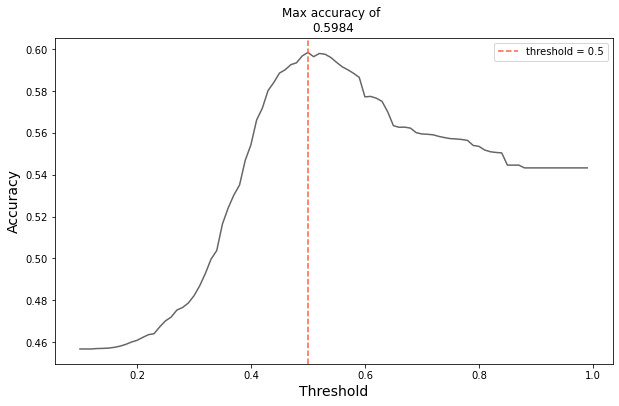

In [104]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.set_xlabel('Threshold', fontsize = 14)
ax.set_ylabel('Accuracy', fontsize = 14)
ax.plot(threshold_list, accuracy_list, color = 'black', alpha = 0.6)
ax.axvline(x=0.5, color = 'tomato', linestyle = '--', label = 'threshold = 0.5')
ax.set_title('Max accuracy of \n{}'.format(round(max(accuracy_list), 4)))

plt.legend()

plt.show()

For saving some time, let's save the data used so far as csv files
to be easier to use from now on

In [107]:
X.to_csv('X.csv', index = False)
X_ohe.to_csv('X_ohe.csv', index = False)
df2018_clf['above_below_avg_cn'].to_csv('y_cn.csv', index = False)
df2018_clf['above_below_avg_ch'].to_csv('y_ch.csv', index = False)
df2018_clf['above_below_avg_lc'].to_csv('y_lc.csv', index = False)
df2018_clf['above_below_avg_mt'].to_csv('y_mt.csv', index = False)
df2018_clf['above_below_avg_red'].to_csv('y_red.csv', index = False)

## Analyzing the features which are clearly not categorical

Let's split the data into X and y and treat and encode the categorical features

## Testing some models

Our baseline model is going to be a simple logistic regression model.
However, in an attempt to do so, we will try to understand the most relevant
features of our problem.

In [28]:
## Scaling the data for PCA analysis

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [50]:
from sklearn.decomposition import PCA

pca = PCA(40)

pca.fit(X_scaled)
pca_data = pca.transform(X_scaled)

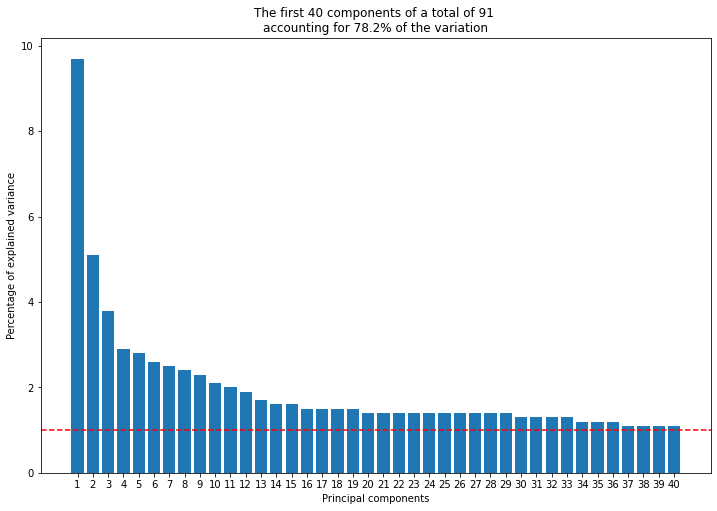

In [55]:
## Percentage of the variation
per_variation = np.round(pca.explained_variance_ratio_*100, decimals = 1)

## Labels for the principal components
labels = [str(x) for x in range(1, len(per_variation) + 1)]


fig, ax = plt.subplots(figsize = (12, 8))

ax.bar(x = range(1, len(per_variation) + 1), height = per_variation, tick_label = labels)

n_components = len(per_variation)
total_var = round(per_variation.sum(), 2)
n_total = len(X.columns)

ax.set_ylabel('Percentage of explained variance')
ax.set_xlabel('Principal components')
ax.set_title('The first {} components of a total of {} \naccounting for {}% of the variation'.format(n_components, n_total, total_var))

ax.axhline(y = 1, c = 'red', linestyle = '--')

plt.show()

In [43]:
per_variation.sum()

52.199999999999996

Let's start by analyzing the natural science subject (it will serve as a model for the rest as well)



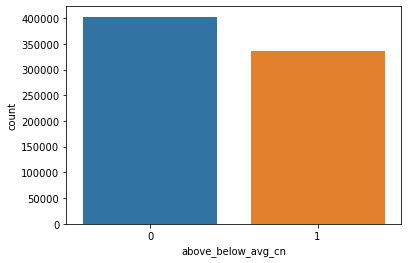

In [25]:
## Analyzing the distribution of cn 

sns.countplot(y_cn)
plt.show()

Let's start creating a baseline model using a RF classifier. Afterwards we can try
to perform some optimization and then testing other models

## Testing a Random Forest Classifier - a baseline model

In [28]:
# Creating the classifier

X_train, X_test, y_train, y_test = train_test_split(X, y_cn, train_size = 0.8, random_state = 0)

clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)

Accuracy: 0.664 
[[63919 16604]
 [33073 34239]]


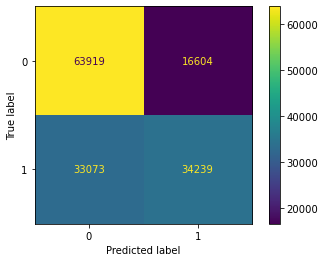

In [30]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 4))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf_rf, X = X_test)

plt.show()

Okay, so the model is not as good as I expected, let's see if it's possible
to improve the model's performance by dropping some components.

In [32]:
def plot_feature_importance(model):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns[:15])),
                               columns=['Value','Feature'])

    plt.figure(figsize=(14, 8))
    sns.barplot(x="Value", y="Feature", data = feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Features', fontsize = 16)
    plt.tight_layout()
    plt.show()

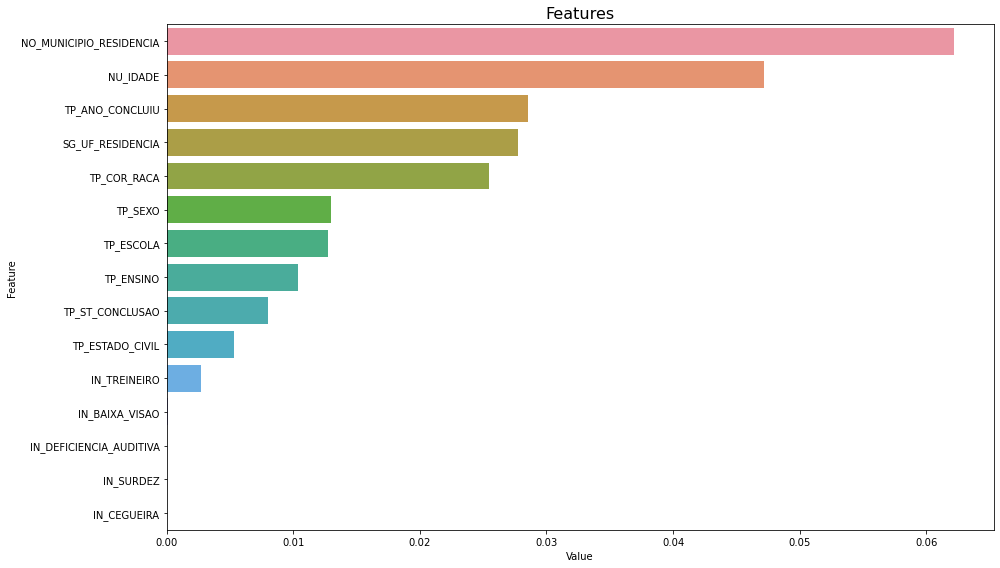

In [32]:
plot_feature_importance(clf)

## Partial discussion

So we observe that among the 15 most important features of our model those last
four ones have basically no impact in this baseline model. Let's as a first try,
then discard all the features below "IN_TREINEIRO" and see if it improves our models accuracy.

In [31]:
cols = ['NU_IDADE', 'TP_ANO_CONCLUIU', 'SG_UF_RESIDENCIA', 'TP_SEXO',
        'TP_COR_RACA', 'NO_MUNICIPIO_RESIDENCIA', 'TP_ENSINO', 'TP_ESCOLA',
        'TP_ST_CONCLUSAO', 'TP_ESTADO_CIVIL', 'IN_TREINEIRO']

X_min = X[cols].copy()

# Creating the classifier

X_train, X_test, y_train, y_test = train_test_split(X_min, y_cn, train_size = 0.8, random_state = 0)

clf_min = RandomForestClassifier()

clf_min.fit(X_train, y_train)

y_pred = clf_min.predict(X_test)

Accuracy: 0.5976 
[[53409 27114]
 [32377 34935]]


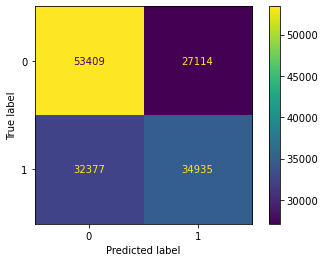

In [33]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 4))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf_min, X = X_test)

plt.show()

This decision decreases the model's performance. Let's see if we add the questions
regarding the social information

In [34]:
#list(X_min.columns)+list(X.columns[-29:-4])
cols_test = list(X_min.columns)+list(X.columns[-29:-4])

X_min = X[cols_test].copy()

In [49]:
# Creating the classifier

X_train, X_test, y_train, y_test = train_test_split(X_min, y_cn, train_size = 0.8, random_state = 0)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy: 0.66 
[[62904 17619]
 [33187 34125]]


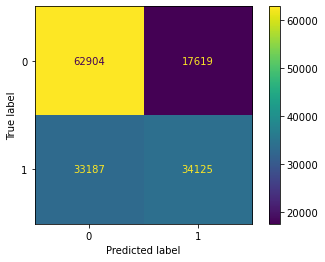

In [50]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()

#Accuracy: 0.66 
#[[63960 16563]
#[33107 34205]]


## Comparison between the two confusion matrices

- We observe that after removing the features our model essentially predicted wrongly
1000 more people which scored below the mean (it predicts that they scored above the mean),
although our accuracy was kept the same. However, the changes in the confusion matrix
were not in the direction we are looking for. The main concern of our model is to predict
those which are scoring below the average. Since our new model is spoting rhougly 1000 people
less in the above of average label, we might stick with the full model and try to decrease
the number of features afterwards.


## Next steps

Sure that trying to go beyond the baseline model might lead to an accuracy improvement,
however we are simply using a RF classifier for the prediction, we aim to use later on
XGBoost, LightGBM and CatBoost, whereas the first seems to have some problems with large
amount of features the other two seems to perform better with large amount of categorical
features.
- There are a huge amount of the features related to social information that might not be
properly handled by the *LabelEncoder*, which despite not having a value per se, they have
important implications on the "social ladder" for example, generally parents with higher
salaries can enroll their children in better schools and it, consequently, might affect
the grade. Let's then go through all the questions and handle them properly.

In [35]:
cols = ['above_below_avg_cn', 'above_below_avg_ch', 'above_below_avg_lc', 'above_below_avg_mt', 'above_below_avg_red']

X = df2018_clf.drop(columns = cols).copy()


Q001 and Q002 corresponds to the parents education level, father and mother, respectively.
Despite of not being a direct correspondence, those which achieve a higher level of education
**tend** to have a better chance to haver higher salaries and all that we have already discussed.
Let's then set a numerical order to them

In [42]:
#X.loc[:, X.columns != cols] = X.loc[:, X.columns != cols].apply(LabelEncoder().fit_transform)

#X.head()

X[X.columns.difference(cols)] = X[X.columns.difference(cols)].apply(LabelEncoder().fit_transform)

In [62]:
# Creating the classifier with the new featuretable

X_train, X_test, y_train, y_test = train_test_split(X, y_cn, train_size = 0.8, random_state = 0)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy: 0.66 
[[63755 16768]
 [32892 34420]]


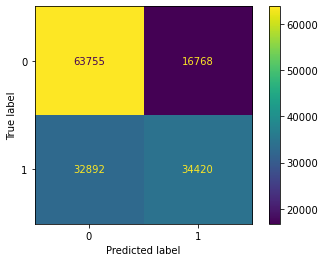

In [63]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()
#[[63960 16563]
#[33107 34205]]

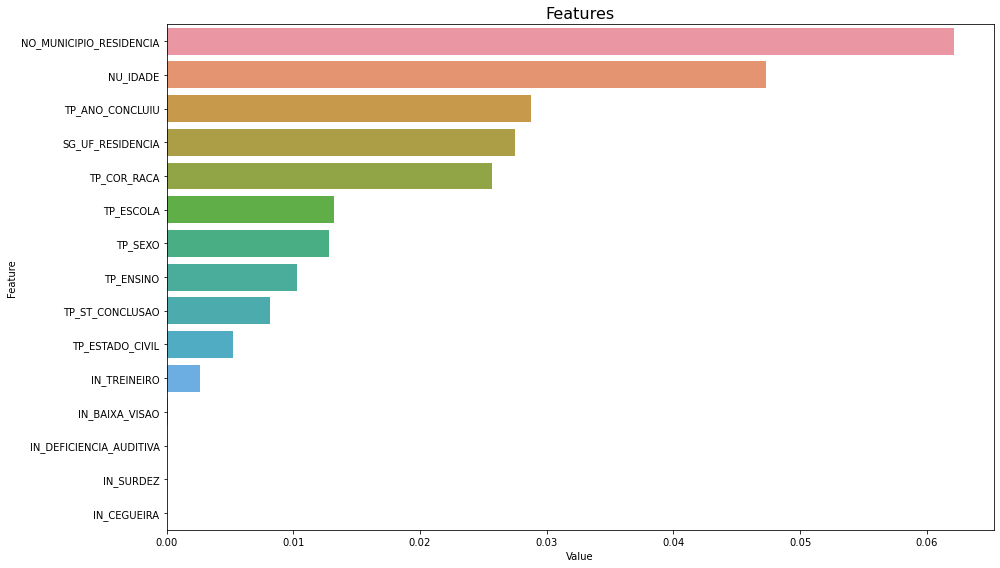

In [64]:
plot_feature_importance(clf)

In [65]:
cols_test = list(X_min.columns)+list(X.columns[-29:-4])

X_min = X[cols_test].copy()

In [68]:
# Creating the classifier with the new featuretable

X_train, X_test, y_train, y_test = train_test_split(X_min, y_cn, train_size = 0.8, random_state = 0)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy: 0.65 
[[62490 18033]
 [33061 34251]]


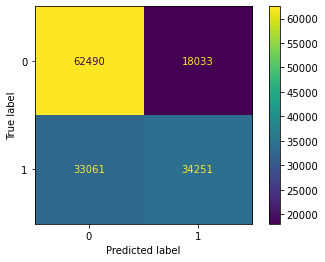

In [69]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()

## Saving the data for future purpose

Before going into XGBoost classifier, let's save the data already treated

In [47]:
#X.to_csv('X.csv')
#X_min.to_csv('X_min.csv')
df2018_clf['above_below_avg_cn'].to_csv('y_cn.csv')
df2018_clf['above_below_avg_ch'].to_csv('y_ch.csv')
df2018_clf['above_below_avg_lc'].to_csv('y_lc.csv')
df2018_clf['above_below_avg_mt'].to_csv('y_mt.csv')
df2018_clf['above_below_avg_red'].to_csv('y_red.csv')

## XGboost classifier

Let's start analyzing other classifiers and see how they perform
on our dataset prior to any hyperparameter tunning

In [12]:
X_min = pd.read_csv('X_min.csv', index_col = [0])
y_cn = pd.read_csv('y_cn.csv', index_col = [0])

Accuracy: 0.67 
[[63548 16975]
 [32197 35115]]


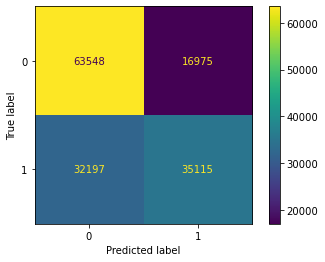

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_min, y_cn, train_size = 0.8,
                                                    random_state = 0)

clf = XGBClassifier(objective = 'binary:logistic', seed = 0)

clf.fit(X_train, y_train, verbose = False,
        eval_metric = 'logloss',
        eval_set = [(X_test, y_test)],
        early_stopping_rounds = 10)

y_pred = clf.predict(X_test)

print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()

Accuracy: 0.67 
[[63548 16975]
 [32197 35115]]


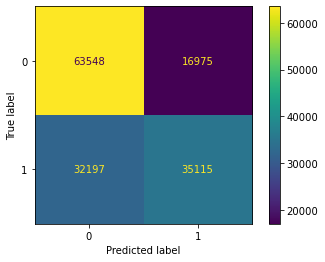

In [37]:
## Lets check X_min without the city category

X_min2 = X_min.drop(columns = ['NO_MUNICIPIO_RESIDENCIA'])

X_train, X_test, y_train, y_test = train_test_split(X_min2, y_cn, train_size = 0.8,
                                                    random_state = 0)

clf = XGBClassifier(objective = 'binary:logistic', seed = 0)

clf.fit(X_train, y_train, verbose = False,
        eval_metric = 'logloss',
        eval_set= [(X_test, y_test)],
        early_stopping_rounds = 10)

y_pred = clf.predict(X_test)

print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()

Nice, without any parameter tuning it got one percent better.
Also, we after removing the city we managed to  increase the number
of predictions for those which scored below the mean.

It is rather common to see improvements of 5% to 10% after
parameter tuning, so we expect to cross the threshold of 70%.

Lets start by looking at the number of trees in our forest

In [38]:
X_min = X_min2.copy()

er_train = []
er_test = []
n_ests = []

## Setting the feature table and the target into the DMatrix format
D_train = xgb.DMatrix(X_train, label = y_train)
D_test = xgb.DMatrix(X_test, label = y_test)

## Some parameters that won't be updated
eval_metric = ['auc', 'error']
eval_set = [(X_train, y_train), (X_test, y_test)]

for n_estimators in range(20, 420, 20):
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        max_depth = 2, n_estimators = n_estimators)

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 50)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    error_train = round(1 - accuracy_score(y_train, y_pred_train), 2)
    error_test = round(1 - accuracy_score(y_test, y_pred_test), 2)
    
    er_train.append(error_train)
    er_test.append(error_test)
    n_ests.append(n_estimators)
    print(n_estimators)
    

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400


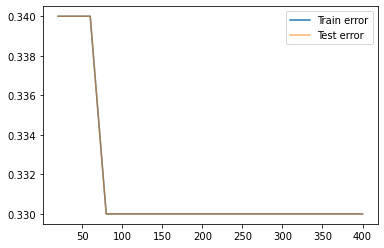

In [39]:
fig, ax = plt.subplots()

ax.plot(n_ests, er_train, label = 'Train error')
ax.plot(n_ests, er_test, label = 'Test error', alpha = 0.6)

plt.legend()
plt.show()

Checking its fine tune

In [40]:
er_train = []
er_test = []
n_ests = []

for n_estimators in range(20, 180, 20):
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        max_depth = 6, n_estimators = n_estimators)

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 50)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    error_train = round(1 - accuracy_score(y_train, y_pred_train), 2)
    error_test = round(1 - accuracy_score(y_test, y_pred_test), 2)
    
    er_train.append(error_train)
    er_test.append(error_test)
    n_ests.append(n_estimators)
    print(n_estimators)
    

20
40
60
80
100
120
140
160


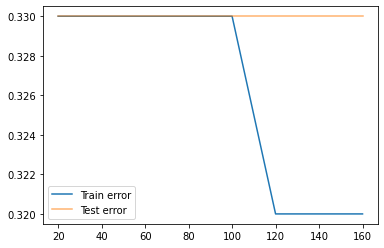

In [41]:
fig, ax = plt.subplots()

ax.plot(n_ests, er_train, label = 'Train error')
ax.plot(n_ests, er_test, label = 'Test error', alpha = 0.6)

plt.legend()
plt.show()

Let's them keep 120 trees and we will tune the other parameters below

### Max depth optimization

In [48]:
for max_depth in [2, 5, 10, 20]:
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        n_estimators = 120,
                        max_depth = max_depth)

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 12)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 2)
    acc_test = round(accuracy_score(y_test, y_pred_test), 2)
    
    
    print ('Accuracy analysis for {} levels in the tree:'.format(max_depth))
    print (' ')
    print ('Accuracy on the training set: {}'.format(acc_train))
    print ('Accuracy on the testing set: {}'.format(acc_test))
    print ('----------------------------------------------')
    print (' ')

Accuracy analysis for 2 levels in the tree:
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for 5 levels in the tree:
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for 10 levels in the tree:
 
Accuracy on the training set: 0.69
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for 20 levels in the tree:
 
Accuracy on the training set: 0.88
Accuracy on the testing set: 0.64
----------------------------------------------
 


Interestingly we clearly observe a beginning of overfitting for max_depth = 10
it becomes astonishing for max_depth = 20, where the accuracy on the training
set goes up, to 0.88, and the accuracy on the testing set drops to 0.64. Let's
stick with max_depth = 3, for instance.

### Learning rate - eta - optimization

In [49]:
for eta  in [0.01, 0.05, 0.1, 0.3]:
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        n_estimators = 120, max_depth = 3,
                        eta = eta)

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 12)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 2)
    acc_test = round(accuracy_score(y_test, y_pred_test), 2)
    
    
    print ('Accuracy analysis for eta = {}'.format(eta))
    print (' ')
    print ('Accuracy on the training set: {}'.format(acc_train))
    print ('Accuracy on the testing set: {}'.format(acc_test))
    print ('----------------------------------------------')
    print (' ')

Accuracy analysis for eta = 0.01
 
Accuracy on the training set: 0.64
Accuracy on the testing set: 0.64
----------------------------------------------
 
Accuracy analysis for eta = 0.05
 
Accuracy on the training set: 0.66
Accuracy on the testing set: 0.66
----------------------------------------------
 
Accuracy analysis for eta = 0.1
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.66
----------------------------------------------
 
Accuracy analysis for eta = 0.3
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 


We observe that for eta = 0.01 we do not even reach the baseline model's
accuracy (0.67), we stop prior to that on 0.64. Let's increase the number of 
trees to go further in the boosting process and see how far we can get

In [52]:
clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                    n_estimators = 1200, max_depth = 3,
                    eta = 0.01)

clf.fit(X_train, y_train, verbose = False,
        eval_metric = eval_metric,
        eval_set = eval_set,
        early_stopping_rounds = 120)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

acc_train = round(accuracy_score(y_train, y_pred_train), 2)
acc_test = round(accuracy_score(y_test, y_pred_test), 2)


print ('Accuracy analysis for eta = {}'.format(0.01))
print (' ')
print ('Accuracy on the training set: {}'.format(acc_train))
print ('Accuracy on the testing set: {}'.format(acc_test))
print ('----------------------------------------------')
print (' ')

Accuracy analysis for eta = 0.01
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.66
----------------------------------------------
 


Okay, so we stick with our eta = 0.3 since it has no further improvement.

### Bagging parameters

XGBoost alows us to perform bagging as one of the features to avoid overfitting.
Although it seems we are not doing so, let's investigate if we can achieve a
better accuracy by changing the percentage of rows chosen for the boosting
and the percentage of features used

In [55]:
for subsample  in [0.7, 0.75, 0.8, 0.85, 0.9]:
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        n_estimators = 120, max_depth = 3, eta = 0.3,
                        subsample = subsample)

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 12)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 2)
    acc_test = round(accuracy_score(y_test, y_pred_test), 2)
    
    
    print ('Accuracy analysis for a subsample of {}'.format(subsample))
    print (' ')
    print ('Accuracy on the training set: {}'.format(acc_train))
    print ('Accuracy on the testing set: {}'.format(acc_test))
    print ('----------------------------------------------')
    print (' ')

Accuracy analysis for a subsample of 0.7
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for a subsample of 0.75
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for a subsample of 0.8
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for a subsample of 0.85
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for a subsample of 0.9
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 


In [57]:
## Percentage of features

for colsample_bytree  in [0.7, 0.75, 0.8, 0.85, 0.9]:
    clf = XGBClassifier(objective = 'binary:logistic', seed = 0,
                        n_estimators = 120, max_depth = 3, eta = 0.3, subsample = 0.8,
                        colsample_bytree = colsample_bytree
                        )

    clf.fit(X_train, y_train, verbose = False,
            eval_metric = eval_metric,
            eval_set = eval_set,
            early_stopping_rounds = 12)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    acc_train = round(accuracy_score(y_train, y_pred_train), 2)
    acc_test = round(accuracy_score(y_test, y_pred_test), 2)
    
    
    print ('Accuracy analysis for {} percentage of features'.format(colsample_bytree))
    print (' ')
    print ('Accuracy on the training set: {}'.format(acc_train))
    print ('Accuracy on the testing set: {}'.format(acc_test))
    print ('----------------------------------------------')
    print (' ')

Accuracy analysis for 0.7 percentage of features
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for 0.75 percentage of features
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for 0.8 percentage of features
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for 0.85 percentage of features
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 
Accuracy analysis for 0.9 percentage of features
 
Accuracy on the training set: 0.67
Accuracy on the testing set: 0.67
----------------------------------------------
 


Cool, probably due to the amount of data that we have, using a smaller
part of the features seems to not affect the model's performance.

Another idea that come to my mind is: *what if we only provide the
social information to the model? How does it perform?*

Lets take a quick look on it starting by the RandomForest model

In [81]:
X_qtn = X_min.iloc[:, 10:].copy()

X_qtn.head()

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
1,1,1,0,0,3,1,0,1,2,0,...,0,0,0,1,0,0,1,0,0,0
5,2,3,2,1,0,1,0,1,2,0,...,1,0,0,1,0,0,1,0,1,1
7,0,4,0,3,3,7,0,1,2,0,...,0,0,0,2,1,0,1,0,1,1
8,3,3,2,1,6,2,0,1,2,0,...,0,0,0,1,1,0,1,0,0,0
9,2,2,2,1,0,2,0,1,1,0,...,0,0,0,1,0,0,1,0,0,0


Accuracy for the training set: 1.0 
Accuracy for the testing set: 0.66 


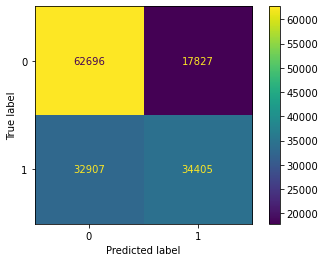

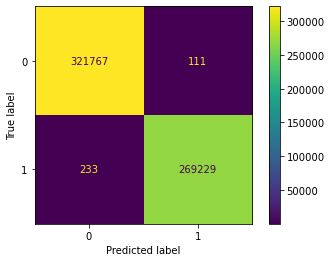

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_min, y_cn, train_size = 0.8,
                                                    random_state = 0)

clf = RandomForestClassifier(max_features = 'sqrt')

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print('Accuracy for the training set: {} '.format(round(accuracy_score(y_train, y_pred_train), 2))) 
print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test, y_pred_test), 2)))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)
plot_confusion_matrix(y_true = y_train, estimator = clf, X = X_train)

plt.show()

Wow! Okay, quite surprising! For sure we are performing some
overfitting, but can we do better with that? Lets find out.
If it doesn't work and we keep stuck at .66~.67 of accuracy,
we might move on to LightGBM

In [97]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Okay, quite easy to see why we have so much overfitting. It is a well with no bottom haha.
Let's start by setting a max_depth

In [104]:
for max_depth in [3, 5, 10, 20]:
    clf = RandomForestClassifier(max_depth = max_depth, max_features = 'sqrt')

    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    print('Accuracy for the training set: {} '.format(round(accuracy_score(y_train, y_pred_train), 2))) 
    print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test, y_pred_test), 2)))

Accuracy for the training set: 0.65 
Accuracy for the testing set: 0.65 
Accuracy for the training set: 0.65 
Accuracy for the testing set: 0.65 
Accuracy for the training set: 0.66 
Accuracy for the testing set: 0.66 
Accuracy for the training set: 0.82 
Accuracy for the testing set: 0.66 


Although we see a small improvement for max_depth = 10. We start seeing the overfitting
taking off for max_depth = 20, as we have seen before.

Now, let's move towards LightGBM and see how it performs, try to make some
hyperparameter tunning and see how it performs, if we have any improvement.

## LightGBM classifier

Let's start by taking into account all the features similar to what we have done before

In [54]:
X = pd.read_csv('X.csv', index_col = 'Unnamed: 0')
y_cn = pd.read_csv('y_cn.csv', index_col = 'Unnamed: 0')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cn, test_size = 0.2, random_state = 0)


clf = lgb.LGBMClassifier()

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print('Accuracy for the training set: {} '.format(round(accuracy_score(y_train, y_pred_train), 2))) 
print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test, y_pred_test), 2)))

Accuracy for the training set: 0.68 
Accuracy for the testing set: 0.67 


Schön! This is quite good. Using the baseline model of LightGBM we observe
that we obtained the best score in testing set and a not much higher score
in the training set, which might be a spot light in the end of this dark tunnel.
Let's perform the same tests as before and see what happens.

### Feature importance

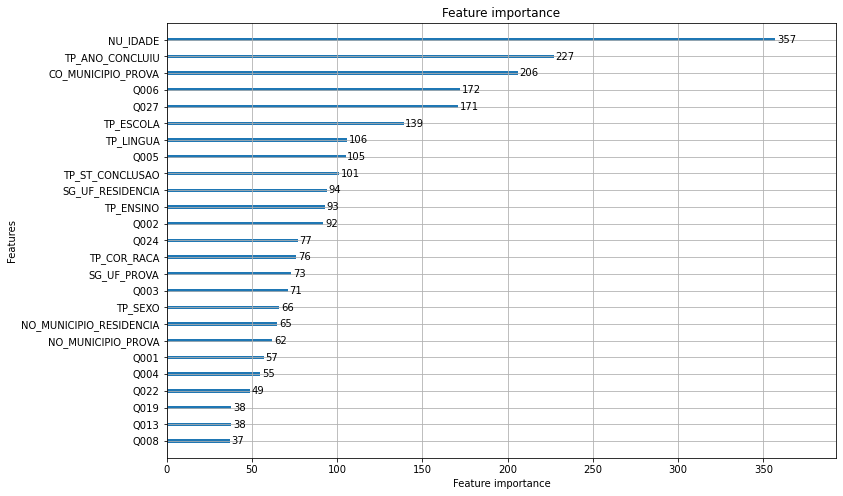

In [56]:
feature_importance = lgb.plot_importance(clf, max_num_features = 25, figsize = (12, 8))

plt.show()

That's trully amazing! It was already expected that the social questions
would play an important role in the model, although it was not observed
directly in the feature importance that we have worked before. However,
we also have seen that adding them to the first 15 most important features
increased models accuracy in roughly 10%. This time we observe that they
already started appearing in the first top5 features, where Q006 is related
to the income of the family and Q027 is related to the kind of school
that the applicants studied during high school. Just amazing :-)

Let's analyze what happens if stick with only the first 25 features

In [57]:
features_25 = []
for feature in feature_importance.get_yticklabels():
    features_25.append(feature.get_text())

X_25 = X[features_25].copy()
X_25.head()

,Q008,Q013,Q019,Q022,Q004,Q001,NO_MUNICIPIO_PROVA,NO_MUNICIPIO_RESIDENCIA,TP_SEXO,Q003,...,SG_UF_RESIDENCIA,TP_ST_CONCLUSAO,Q005,TP_LINGUA,TP_ESCOLA,Q027,Q006,CO_MUNICIPIO_PROVA,TP_ANO_CONCLUIU,NU_IDADE
1,1,0,1,1,1,1,1488,4680,0,1,...,9,0,4,0,0,0,1,281,5,23.00
5,1,0,1,1,2,2,814,2455,0,3,...,14,0,1,1,0,0,1,515,5,23.00
7,1,0,2,1,4,0,1117,3412,1,1,...,16,0,4,0,0,0,7,315,12,39.00
8,1,0,1,1,2,3,567,1700,1,3,...,5,1,7,0,1,0,2,368,-999,19.00
9,1,0,1,1,2,2,476,1362,0,3,...,12,0,1,1,0,0,2,1630,9,25.00


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_25, y_cn, test_size = 0.2, random_state = 0)

clf_red = lgb.LGBMClassifier()

clf_red.fit(X_train, y_train)

y_pred_train = clf_red.predict(X_train)
y_pred_test = clf_red.predict(X_test)

print('Accuracy for the training set: {} '.format(round(accuracy_score(y_train, y_pred_train), 4))) 
print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test, y_pred_test), 4)))

Accuracy for the training set: 0.6755 
Accuracy for the testing set: 0.6725 


So we can drammatically reduce the number of feature (95 to 25 features)
and keep the same accuracy.

### Hyperparameter tunning in LightGBM

Despite of all similarities, LightGBM has a a significant
difference when compared to XGBoost: whereas the latter
is based in the is a tree growth based algorithm and the
main ways to control the complexity of the tree is through max_depth,
that is not directly true for the former. LightGBM bases itself
on the number of leaves, which might be connect to how shallow/deeper
is the tree, but **not necessarily**. For further information check the
[documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

In [169]:
for num_leaves in [2, 4, 8, 32, 64, 128, 256, 512, 1024, 2056]:
    clf = lgb.LGBMClassifier(num_leaves = num_leaves)

    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    print('Accuracy analysis for {} leaves'.format(num_leaves))
    print(' ')
    print('Accuracy for the training set: {} '.format(round(accuracy_score(y_train, y_pred_train), 3))) 
    print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test, y_pred_test), 3)))
    print('------------------------------------------------------------')

Accuracy analysis for 2 leaves
 
Accuracy for the training set: 0.663 
Accuracy for the testing set: 0.662 
------------------------------------------------------------
Accuracy analysis for 4 leaves
 
Accuracy for the training set: 0.668 
Accuracy for the testing set: 0.667 
------------------------------------------------------------
Accuracy analysis for 8 leaves
 
Accuracy for the training set: 0.671 
Accuracy for the testing set: 0.67 
------------------------------------------------------------
Accuracy analysis for 32 leaves
 
Accuracy for the training set: 0.675 
Accuracy for the testing set: 0.672 
------------------------------------------------------------
Accuracy analysis for 64 leaves
 
Accuracy for the training set: 0.679 
Accuracy for the testing set: 0.672 
------------------------------------------------------------
Accuracy analysis for 128 leaves
 
Accuracy for the training set: 0.686 
Accuracy for the testing set: 0.672 
--------------------------------------------

We observe that from 8 to 32 leaves we have a small improvement
in the accuracy for the testing set and an even bigger accuracy
improvement in the training set. From 32 to onwards this discrepancy
keep increasing and one doesn't have observer any improvement in the
accuracy of the testing set. Therefore, let's keep num_leaves = 32.
It could also be okay to take num_leaves, but let's stick with the former.


### Minimum data in leaf tuning
This tells us about the minimum amount of data to be in in a leaf. This
is quite helpful in some cases because it helps to avoid trees to grow
too deeply. However, in our case it is not that helpful, since we are
basically not overfitting. But let's play with some values.

In [174]:
for min_child_samples in [20, 100, 1000, 5000, int(1e4)]:# default = 20
    clf = lgb.LGBMClassifier(num_leaves = 8, min_data_in_leaf = min_child_samples)

    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    print('Accuracy analysis for minimum of {} per leaf'.format(min_child_samples))
    print(' ')
    print('Accuracy for the training set: {} '.format(round(accuracy_score(y_train, y_pred_train), 3))) 
    print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test, y_pred_test), 3)))
    print('------------------------------------------------------------')

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Accuracy analysis for minimum of 20 per leaf
 
Accuracy for the training set: 0.671 
Accuracy for the testing set: 0.67 
------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Accuracy analysis for minimum of 100 per leaf
 
Accuracy for the training set: 0.671 
Accuracy for the testing set: 0.67 
------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
Accuracy analysis for minimum of 1000 per leaf
 
Accuracy for the training set: 0.671 
Accuracy for the testing set: 0.67 
------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be

As we expected it played no role in our model's improvement. Let's try other parameters

### Learning rate and number of iterations

In [179]:
num_iterations = 1000

for eta in [0.01, 0.05, 0.1, 0.3]:
    clf = lgb.LGBMClassifier(num_leaves = 8, learning_rate = eta, num_trees = num_iterations)

    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    print('Accuracy analysis for {} of learning rate'.format(eta))
    print(' ')
    print('Accuracy for the training set: {} '.format(round(accuracy_score(y_train, y_pred_train), 3))) 
    print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test, y_pred_test), 3)))
    print('------------------------------------------------------------')

Accuracy analysis for 0.01 of learning rate
 
Accuracy for the training set: 0.671 
Accuracy for the testing set: 0.67 
------------------------------------------------------------
[LightGBM] [Warning] num_iterations is set=1000, num_trees=1000 will be ignored. Current value: num_iterations=1000
Accuracy analysis for 0.05 of learning rate
 
Accuracy for the training set: 0.676 
Accuracy for the testing set: 0.673 
------------------------------------------------------------
[LightGBM] [Warning] num_iterations is set=1000, num_trees=1000 will be ignored. Current value: num_iterations=1000
Accuracy analysis for 0.1 of learning rate
 
Accuracy for the training set: 0.679 
Accuracy for the testing set: 0.674 
------------------------------------------------------------
[LightGBM] [Warning] num_iterations is set=1000, num_trees=1000 will be ignored. Current value: num_iterations=1000
Accuracy analysis for 0.3 of learning rate
 
Accuracy for the training set: 0.687 
Accuracy for the testing 

Schön! We managed to improve it a little bit!!! However, we
might be able to improve it even more. Let's see what happens if
we increase the number of trees (for eta = 0.01 we didn't reach the
the values associated to 0.05 nor 0.1. To what concerns eta = 0.3,
we can drop it now, since we see that it is overshooting the minimum.

In [10]:
num_trees = 10000

for eta in [0.01, 0.05, 0.1]:
    clf = lgb.LGBMClassifier(num_leaves = 8, learning_rate = eta, num_trees = num_trees)

    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
   
    eval_set = (X_test, y_test)
    early_stopping_rounds = 50
    
    print('Accuracy analysis for {} of learning rate'.format(eta))
    print(' ')
    print('Accuracy for the training set: {} '.format(round(accuracy_score(y_train, y_pred_train), 3))) 
    print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test, y_pred_test), 3)))
    print('------------------------------------------------------------')

[LightGBM] [Warning] num_iterations is set=10000, num_trees=10000 will be ignored. Current value: num_iterations=10000
Accuracy analysis for 0.01 of learning rate
 
Accuracy for the training set: 0.679 
Accuracy for the testing set: 0.674 
------------------------------------------------------------
[LightGBM] [Warning] num_iterations is set=10000, num_trees=10000 will be ignored. Current value: num_iterations=10000
Accuracy analysis for 0.05 of learning rate
 
Accuracy for the training set: 0.693 
Accuracy for the testing set: 0.673 
------------------------------------------------------------
[LightGBM] [Warning] num_iterations is set=10000, num_trees=10000 will be ignored. Current value: num_iterations=10000
Accuracy analysis for 0.1 of learning rate
 
Accuracy for the training set: 0.707 
Accuracy for the testing set: 0.671 
------------------------------------------------------------


Accuracy analysis for 0.1 of learning rate
 
Accuracy for the training set: 0.679 
Accuracy for the testing set: 0.674 

#### Comparing the result for 1000 and 10000 trees
We observe that regarding eta = 0.01, one obtains an increament
in the accuracy of the testing set of 3%, and 8% in the training set.
On the other hand, when eta = 0.05 there is no improvement in
the accuracy of the testing set and an improvement of more than 10%
in the training set. Finally, for eta = 0.1 we observe a deacrement
in the accuracy of the testing set and also in the training set.

So there are two options for us, eta = 0.01 and num_trees = 10000
or eta = 0.1 and num_trees = 1000 (our previous example). So, obviously,
the latter is the option.

# Partial conclusion about what has been achieved so far

### About the models

For this problem specifically we observed that the baseline models, all of them,
started with accuracy above 60%, but we didn't manage to increase its accuracy
much beyond that, even after a detailed parameter tunning in lightgbm and xgboost.
A proper feature engineering might be necessary if one wants to improve its accuracy
and cross the 70% border. An idea to be implemented later is the creation of a 
"social status parameter", which is a composition of several parameters in a single one.


However, before embarking in this journey, let's do some stuff before:

1) Let's analyze the ROC curve of our model and see how it is possible, by changing
the threshold, to improve the model's accuracy.

2) Understand better whether this small improvement can have any impact or not.

In [59]:
clf_lgbm = lgb.LGBMClassifier(num_leaves = 8, learning_rate = 0.1, num_iterations = 1000, random_state = 0)

clf_lgbm.fit(X_train, y_train)

y_pred_train = clf_lgbm.predict(X_train)
y_pred_test = clf_lgbm.predict(X_test)

print('Accuracy for the training set: {} '.format(round(accuracy_score(y_train, y_pred_train), 4))) 
print('Accuracy for the testing set: {} '.format(round(accuracy_score(y_test, y_pred_test), 4)))
print('------------------------------------------------------------')

## Accuracy of Random Forest: 0.664 

Accuracy for the training set: 0.679 
Accuracy for the testing set: 0.6735 
------------------------------------------------------------


In [60]:
threshold_list = []
accuracy_list  = []
for threshold in np.arange(0.1, 1, 0.01):
    threshold = round(threshold, 2)
    predicted_proba = clf_lgbm.predict_proba(X_test)
    predicted = (predicted_proba [:,1] >= threshold).astype('int')

    accuracy = accuracy_score(y_test, predicted)
    
    threshold_list.append(threshold)
    accuracy_list.append(accuracy)

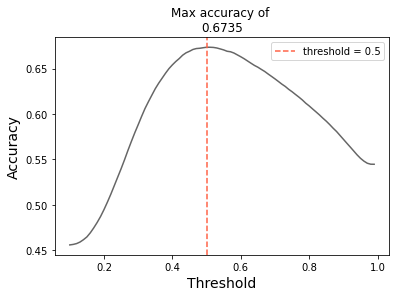

In [61]:
fig, ax = plt.subplots()

ax.set_xlabel('Threshold', fontsize = 14)
ax.set_ylabel('Accuracy', fontsize = 14)
ax.plot(threshold_list, accuracy_list, color = 'black', alpha = 0.6)
ax.axvline(x=0.5, color = 'tomato', linestyle = '--', label = 'threshold = 0.5')
ax.set_title('Max accuracy of \n{}'.format(round(max(accuracy_list), 4)))

plt.legend()

plt.show()

So we observe that indeed this was the better split that we could have done.
Let's then check whether this small improvement has any impact or not.

## Final conclusion about the natural science classification problem

This small improvement is related to students all over the country and it has
for sure an impact on the brazilian economy (and we will analyze how much soon
that could help). Nowadays we are facing a lot of problems regarding people which
do not trust scientific evidences. A program like this could help identifying
the need, or not, of hiring more teachers of physics, chemistry and biology for
an specific area in the country.

Firstly, lets analyze the following: *TP_DEPENDENCIA_ADM_ESC* contains the kind of school
that the applicant came from. Let's see if indeed the majority are coming from public schools

Number of applicants which didn't reply: TP_DEPENDENCIA_ADM_ESC    722625
dtype: int64


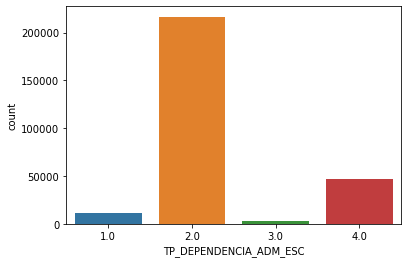

In [77]:
df_tp_escola = pd.read_csv('DADOS/MICRODADOS_ENEM_2018.csv', usecols = ['TP_DEPENDENCIA_ADM_ESC'],
                           nrows = 1000000, sep = ';', encoding = 'ISO-8859-1')


print ("Number of applicants which didn't reply: {}".format(df_tp_escola.isna().sum()))

sns.countplot(df_tp_escola.TP_DEPENDENCIA_ADM_ESC)
plt.show()

##We observe that among those which replied, the vast majority are from public schools

In [89]:
public = len(df_tp_escola[df_tp_escola.TP_DEPENDENCIA_ADM_ESC == 2] )
total = df_tp_escola.TP_DEPENDENCIA_ADM_ESC.notna().sum()

percentage = round(100*public/total, 2)

print('Percentage of students in public school: {}'.format(percentage))

## Let's extrapolate this value for all the applicants.

Percentage of students in public school: 78.02


### Identifying the amount of students from public schools

Since the average of applicants in enem last year was around [5 millions](https://veja.abril.com.br/educacao/com-5-milhoes-de-inscritos-confirmados-enem-segue-tendencia-de-queda/)
we are going to assume that $78\pm 7.8\%$ were from public schools. Being
conservative regarding these numbers, let's take the lower bound of $71.2\%$.
Therefore, 3.560.000 students were from public schools and are paid by the government.

### Identifying the amount of Physics, Chemistry and Biology teachers necessary

The classes in public high schools have the average of $30.5$ students per class, according
to the [Ministery of Education](http://portal.mec.gov.br/component/tags/tag/media.).
Since to complete the studies one needs three years, it means that one student is going
to have nine teachers in natural sciences along the high school.

As we have 3.560.000 students from public schools applying to ENEM, these students, when
grouped together, represent $3.560.000/30.5 \simeq 116.721$ classes, such that each of
these classes during the high school have had $116.721*9 = 1.050.492$ teachers in natural
science. However, the relation is not one teacher per class. Physics and Chemistry for
example have three classes during the week, while Biology has two. Let's take as fixed
value three classes a week. Since most teachers have 20 hours of working hour in class,
it means that each of them have around 7 classes per year. Therefore, we need to divide
the number $1.050.492/7 \simeq 150.070$ and the **number of teachers** to train the students
go through the public high schools is $\simeq 150.070$.


%%%Ensino Médio: R\% 2.872,00

### Project of a governmental plan to improve Science in Brazil

After looking the data, the Federal government observes that there are more students
below the mean rather than above the mean as we show below

In [101]:
above = round(100*y_cn.above_below_avg_cn.sum()/len(y_cn), 2)
below = 100 - above

n_above = y_cn.above_below_avg_cn.sum()
n_below = len(y_cn) - n_above

print('In Brazil {}% of the students are above the mean, whereas {}% are below the mean in Natural Sciences'.format(above, below))

In Brazil 45.56% of the students are above the mean, whereas 54.44% are below the mean in Natural Sciences


In [104]:
print(n_above)
print(n_below)

336774
402401


The government then decides to develop a plan to have at least $50+1\%$
of the students above the mean in Natural Sciences (which implies). For doing so,
they decided to hire more teachers for reinforcement classes for the three
natural sciences subjects.

Since they cannot ensure that investing in $51 - 45.56\% = 5.44\%$ will be approved
right away, they decided to take a margin of error and they want to take four times
more students. That is: $5.44\%*4 = 21.76\%$ of the students which were below the mean.
On the other hand, there is no way to identify these students right away and there is
where the model developed here becomes quite handy.

Among the students, one wants to identify those $21.76\%$ of those which are below the mean,
i.e., $21.76\%$ of $402401 = 87563$ students that will join our special classes for three years.

Our baseline model using all the predictors had an accuracy of $0.664$, and taking the most
important features in the random forest model it drops drastically to $0.5976$. Using my knowledge
on the field I managed to add some a couple of more features and increased it back to $0.66$
using only 1/3 to 1/4 of the initial features.


### Accuracy: 0.664
### Accuracy: 0.5976

336774
402401
